In [19]:
from PBC2_2 import PBC
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from numba import njit, uint64, uint32

import cv2

In [20]:
def compress_and_generate_video(
    img,
    stroke_count,
    stream_interval,
    fps,
    save_filename,
    video_filename,
    **compress_kwargs  # Optional parameters for PBC.compress
):
    """
    Compress an image using PBC and generate a video showing the compression evolution.

    Parameters:
        img (PIL.Image.Image): The input image.
        stroke_count (int): Number of strokes for compression.
        stream_interval (int): Interval for streaming interim results.
        fps (int): Frames per second for the output video.
        save_filename (str): Filename to save the compressed output.
        video_filename (str): Filename for the output video.
        **compress_kwargs: Optional parameters for PBC.compress.
    """
    # Collect all interim compressed images
    frames = []
    loss_history = [[] for _ in range(4)]  # R, G, B, Average

    # Use a for loop to iterate over the generator
    for interim_result in PBC.compress_stream(
        img,
        stroke_count=stroke_count,
        save_filename=save_filename,
        stream_interval=stream_interval,
        **compress_kwargs
    ):
        compressed_img, bit_info, losses, total_bits = interim_result
        avg_loss = (losses[0] + losses[1] + losses[2]) / 3

        # Print progress
        interim_print = (
            f"Progress update: {bit_info} | Size: {total_bits / 8 / 1024:.2f} KB\n"
            f"Losses: {losses}\n"
            f"Average MSE: {avg_loss:.2f}\n"
        )
        print(interim_print, end="\r", flush=True)

        # Append losses
        loss_history[0].append(losses[0])
        loss_history[1].append(losses[1])
        loss_history[2].append(losses[2])
        loss_history[3].append(avg_loss)

        # Convert PIL image to OpenCV format and add to frames
        frame = cv2.cvtColor(np.array(compressed_img), cv2.COLOR_RGB2BGR)
        frames.append(frame)

    # If you want the final result, you can collect it after the loop
    compressed_img, bit_info, losses, total_bits = interim_result

    print("\nFinal Results:")
    print(bit_info)
    print(losses)
    final_mse = int((losses[0] + losses[1] + losses[2]) / 3)
    print(f"Final MSE: {final_mse}")
    compression_rate = img.width * img.height * 3 * 8 / (total_bits)
    print(f"Final Size: {total_bits / 8 / 1024:.2f} KB | Compression Rate: {compression_rate:.2f}x")

    # Plot compression loss over time
    try:
        xticks = np.arange(0, stroke_count + 1, step=stream_interval)
        plt.plot(xticks, loss_history[0], label="Red Channel", color="red")
        plt.plot(xticks, loss_history[1], label="Green Channel", color="green")
        plt.plot(xticks, loss_history[2], label="Blue Channel", color="blue")
        plt.plot(xticks, loss_history[3], label="Average MSE", color="black", linestyle="--", linewidth=2)
        plt.xlabel("Stroke Count")
        plt.ylabel("Average MSE")
        plt.legend()
        plt.title(f"Compression Loss Over Time")
        plt.show()
    except ValueError:
        xticks = np.arange(0, stroke_count + 1, step=stream_interval)
        xticks = np.append(xticks, stroke_count)
        plt.plot(xticks, loss_history[0], label="Red Channel", color="red")
        plt.plot(xticks, loss_history[1], label="Green Channel", color="green")
        plt.plot(xticks, loss_history[2], label="Blue Channel", color="blue")
        plt.plot(xticks, loss_history[3], label="Average MSE", color="black", linestyle="--", linewidth=2)
        plt.xlabel("Stroke Count")
        plt.ylabel("Average MSE")
        plt.legend()
        plt.title(f"Compression Loss Over Time")
        plt.show()


    # Create a video from the collected frames
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Codec for .mp4
    video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved as {video_filename}")

    #plt.imshow(compressed_img)
    #plt.axis('off')
    #plt.title(f'Final Compressed Image\nFinal MSE: {final_mse}')
    #plt.show()

    print(f"Compression Rate: {compression_rate:.2f}x")

    # show a figure of the final compressed image on the left, original image on the right
    # give an overall title saying "Final Compressed Image and Original Image"
    # give a subtitle to that overall title saying "Final MSE: {final_mse} | Compression rate: {compression_rate:.2f}x"
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(compressed_img)
    plt.axis('off')
    plt.title('Final Compressed Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    plt.suptitle(f'Final MSE: {final_mse}\nCompression rate: {compression_rate:.2f}x', fontsize=16)
    plt.show()

(487, 487)


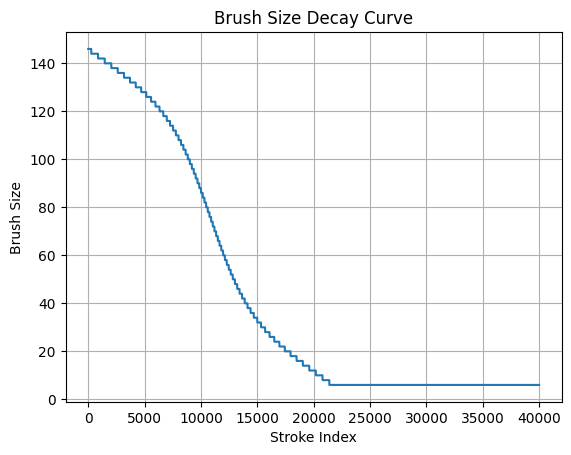

Progress update: Processed 0/40000 strokes. 0.00% | Size: 0.04 KB
Losses: [3119, 2892, 7209]
Average MSE: 4406.67
Progress update: Processed 160/40000 strokes. 0.40% | Size: 0.20 KB
Losses: [1709, 1512, 4589]
Average MSE: 2603.33
Progress update: Processed 320/40000 strokes. 0.80% | Size: 0.35 KB
Losses: [1396, 1385, 3996]
Average MSE: 2259.00
Progress update: Processed 480/40000 strokes. 1.20% | Size: 0.51 KB
Losses: [1286, 1291, 3382]
Average MSE: 1986.33
Progress update: Processed 640/40000 strokes. 1.60% | Size: 0.66 KB
Losses: [1185, 1244, 2909]
Average MSE: 1779.33
Progress update: Processed 800/40000 strokes. 2.00% | Size: 0.82 KB
Losses: [1143, 1167, 2725]
Average MSE: 1678.33
Progress update: Processed 960/40000 strokes. 2.40% | Size: 0.98 KB
Losses: [1128, 1140, 2522]
Average MSE: 1596.67
Progress update: Processed 1120/40000 strokes. 2.80% | Size: 1.13 KB
Losses: [1106, 1083, 2362]
Average MSE: 1517.00
Progress update: Processed 1280/40000 strokes. 3.20% | Size: 1.29 KB
Loss

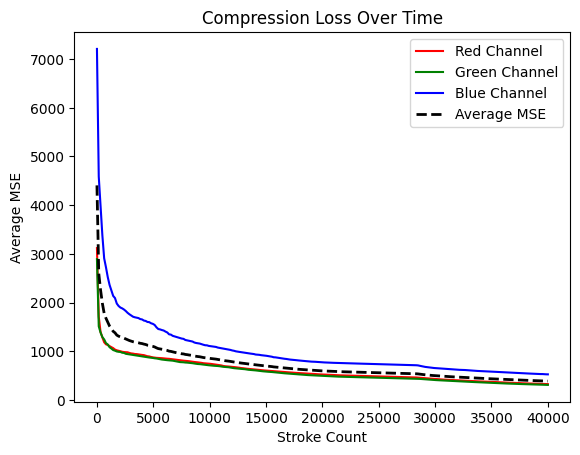

Video saved as compression_evolution_1.mp4
Compression Rate: 17.71x


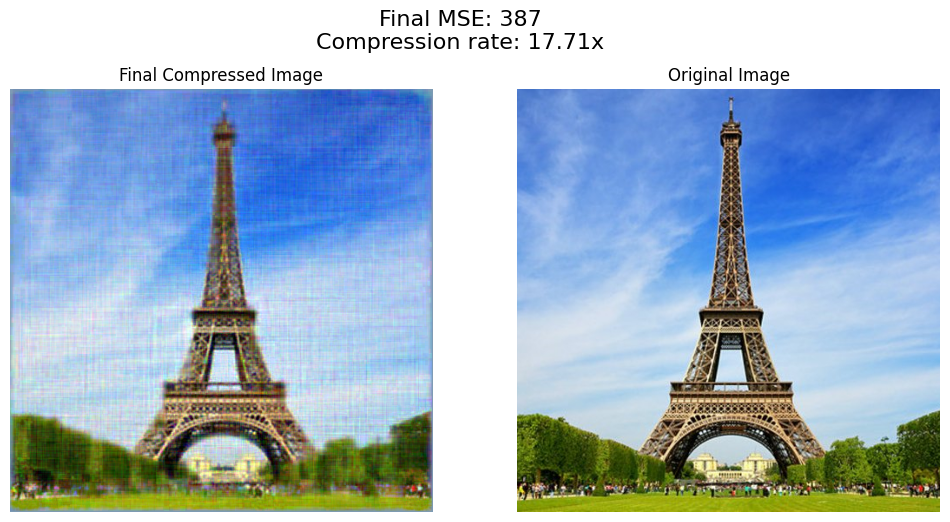

In [13]:
img = Image.open("./test_images/eiffel.png")
save_filename = "numba_newtest.pbc"
video_filename = "compression_evolution_1.mp4"
print(img.size)

stroke_count = 40000
stream_interval = 160
FPS = 60

compress_and_generate_video(
    img,
    stroke_count=stroke_count,
    stream_interval=stream_interval,
    fps=FPS,
    save_filename=save_filename,
    video_filename=video_filename,  
)

(1651, 2477)
Auto-calculated downsample_rate: 3.302
Start color selected: R=49, G=41, B=41
Auto-calculated size start: 0.300
Auto-calculated size end: 0.010
Calculated size range: 151 to 6 pixels.
Auto-calculated cutoff: 0.4321
Auto-calculated softness: 0.5000 (0.5 by default)
Auto-calculated progress: 0.5000 (0.5 by default)


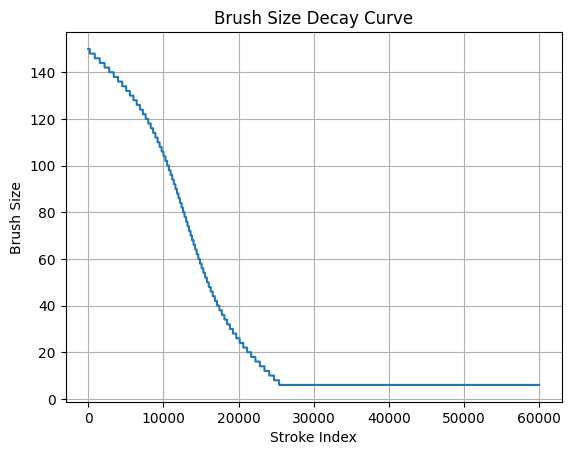

Auto-calculated quadrant_warmup_time: 0.6614
Calculated quadrant_warmup_time: 39683 strokes.
Progress update: Processed 0/60000 strokes. 0.00%
Losses: [3256, 1877, 1940]
Average MSE: 2357.67
Size: 0.0433349609375 KB
Progress update: Processed 160/60000 strokes. 0.27%
Losses: [1756, 971, 1007]
Average MSE: 1244.67
Size: 0.1995849609375 KB
Progress update: Processed 320/60000 strokes. 0.53%
Losses: [1381, 823, 816]
Average MSE: 1006.67
Size: 0.3558349609375 KB
Progress update: Processed 480/60000 strokes. 0.80%
Losses: [1240, 765, 755]
Average MSE: 920.00
Size: 0.5120849609375 KB
Progress update: Processed 640/60000 strokes. 1.07%
Losses: [1164, 722, 716]
Average MSE: 867.33
Size: 0.6683349609375 KB
Progress update: Processed 800/60000 strokes. 1.33%
Losses: [1091, 684, 687]
Average MSE: 820.67
Size: 0.8245849609375 KB
Progress update: Processed 960/60000 strokes. 1.60%
Losses: [1039, 667, 671]
Average MSE: 792.33
Size: 0.9808349609375 KB
Progress update: Processed 1120/60000 strokes. 1.

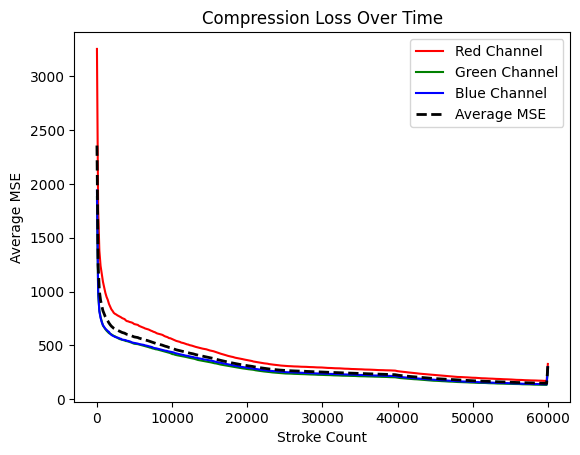

Video saved as compression_evolution_2.mp4
Compression Rate: 203.48x


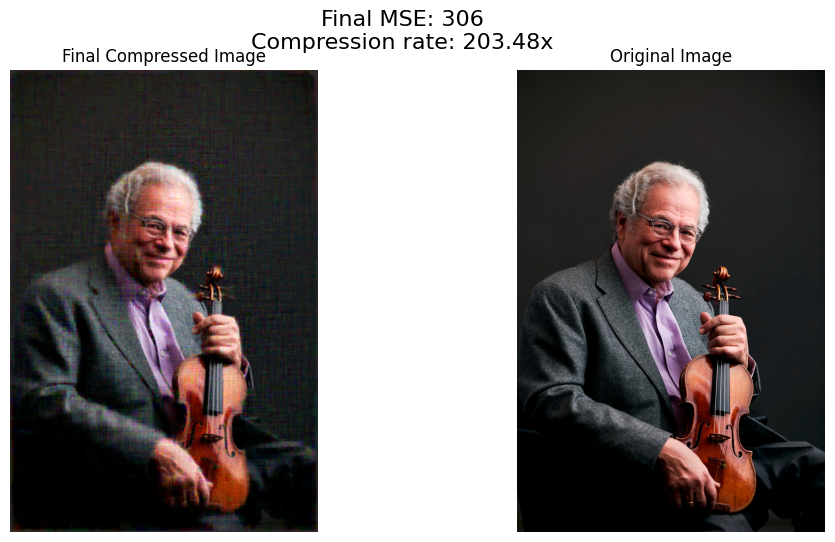

In [6]:
img = Image.open("./test_images/test.png")
save_filename = "numba_newtest2.pbc"
video_filename = "compression_evolution_2.mp4"
print(img.size)

stroke_count = 60000
stream_interval = 160
FPS = 60

compress_and_generate_video(
    img,
    stroke_count=stroke_count,
    stream_interval=stream_interval,
    fps=FPS,
    save_filename=save_filename,
    video_filename=video_filename,

    display_autos=True,
)

(900, 939)


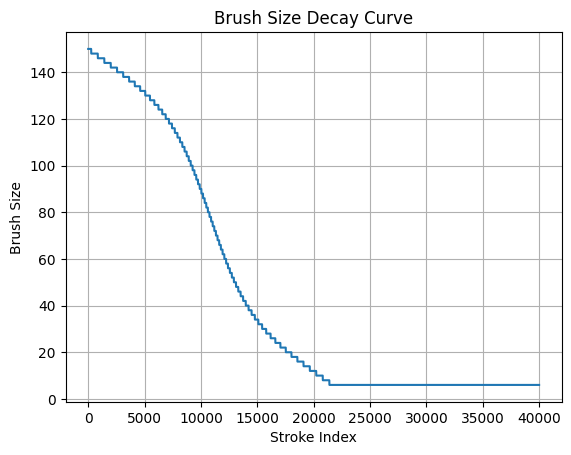

Progress update: Processed 0/40000 strokes. 0.00%
Losses: [1427, 1195, 2032]
Average MSE: 1551.33
Size: 0.0433349609375 KB
Progress update: Processed 160/40000 strokes. 0.40%
Losses: [828, 588, 1014]
Average MSE: 810.00
Size: 0.1995849609375 KB
Progress update: Processed 320/40000 strokes. 0.80%
Losses: [699, 532, 796]
Average MSE: 675.67
Size: 0.3558349609375 KB
Progress update: Processed 480/40000 strokes. 1.20%
Losses: [665, 498, 678]
Average MSE: 613.67
Size: 0.5120849609375 KB
Progress update: Processed 640/40000 strokes. 1.60%
Losses: [638, 487, 635]
Average MSE: 586.67
Size: 0.6683349609375 KB
Progress update: Processed 800/40000 strokes. 2.00%
Losses: [628, 464, 623]
Average MSE: 571.67
Size: 0.8245849609375 KB
Progress update: Processed 960/40000 strokes. 2.40%
Losses: [610, 455, 599]
Average MSE: 554.67
Size: 0.9808349609375 KB
Progress update: Processed 1120/40000 strokes. 2.80%
Losses: [603, 443, 570]
Average MSE: 538.67
Size: 1.1370849609375 KB
Progress update: Processed 1

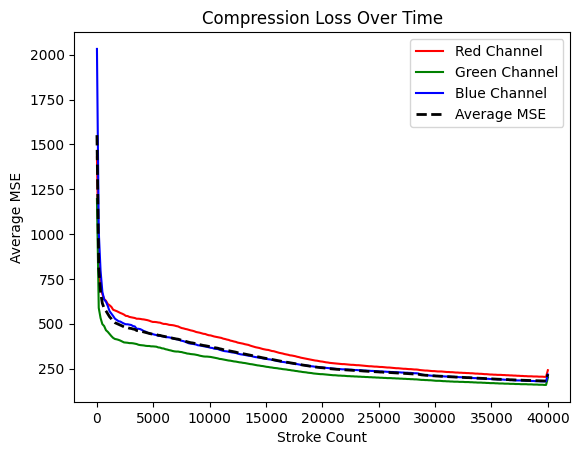

Video saved as compression_evolution_3.mp4
Compression Rate: 63.08x


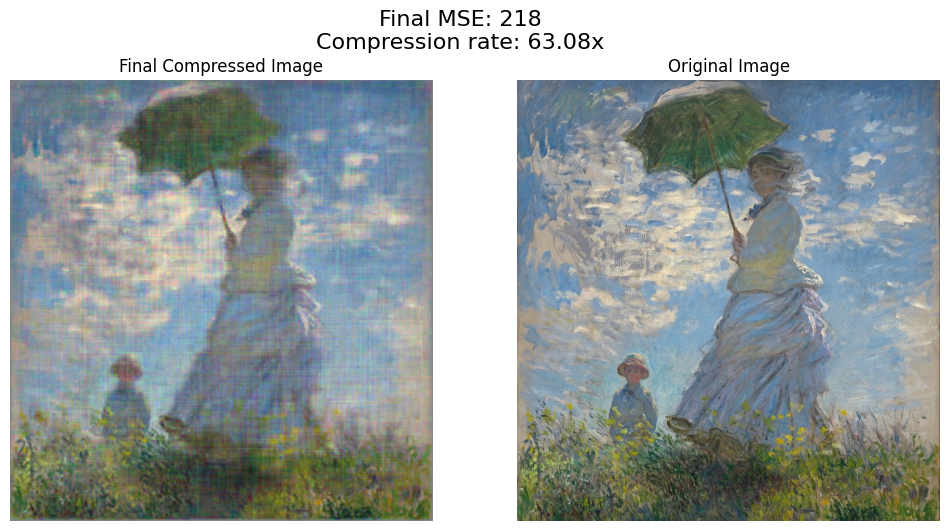

In [7]:
img = Image.open("./test_images/monet.jpg")
save_filename = "numba_newtest_monet.pbc"
video_filename = "compression_evolution_3.mp4"
print(img.size)
stroke_count = 40000
stream_interval = 160
FPS = 60

compress_and_generate_video(
    img,
    stroke_count=stroke_count,
    stream_interval=stream_interval,
    fps=FPS,
    save_filename=save_filename,
    video_filename=video_filename,
)

(400, 400)


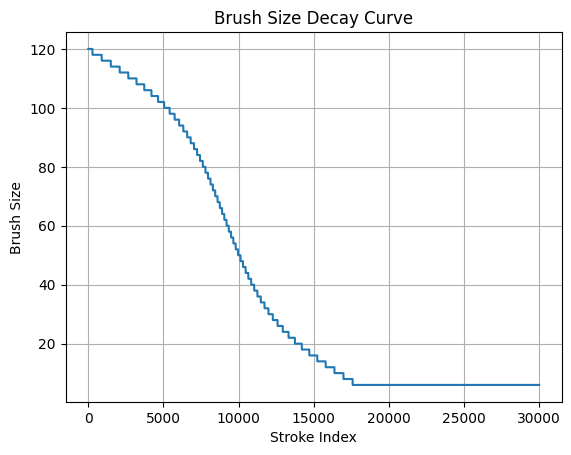

Progress update: Processed 0/30000 strokes. 0.00% | Size: 0.04 KB
Losses: [4397, 2964, 2024]
Average MSE: 3128.33
Progress update: Processed 160/30000 strokes. 0.53% | Size: 0.20 KB
Losses: [2543, 1512, 1021]
Average MSE: 1692.00
Progress update: Processed 320/30000 strokes. 1.07% | Size: 0.35 KB
Losses: [2321, 1267, 858]
Average MSE: 1482.00
Progress update: Processed 480/30000 strokes. 1.60% | Size: 0.51 KB
Losses: [1979, 1173, 781]
Average MSE: 1311.00
Progress update: Processed 640/30000 strokes. 2.13% | Size: 0.66 KB
Losses: [1837, 1102, 750]
Average MSE: 1229.67
Progress update: Processed 800/30000 strokes. 2.67% | Size: 0.82 KB
Losses: [1633, 1026, 738]
Average MSE: 1132.33
Progress update: Processed 960/30000 strokes. 3.20% | Size: 0.98 KB
Losses: [1555, 966, 702]
Average MSE: 1074.33
Progress update: Processed 1120/30000 strokes. 3.73% | Size: 1.13 KB
Losses: [1473, 932, 686]
Average MSE: 1030.33
Progress update: Processed 1280/30000 strokes. 4.27% | Size: 1.29 KB
Losses: [142

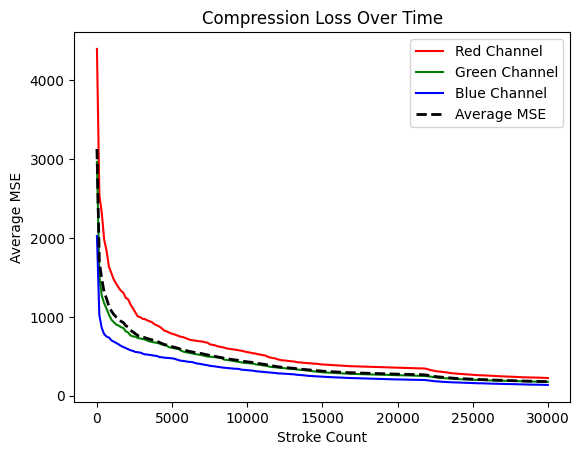

Video saved as compression_evolution_4.mp4
Compression Rate: 15.92x


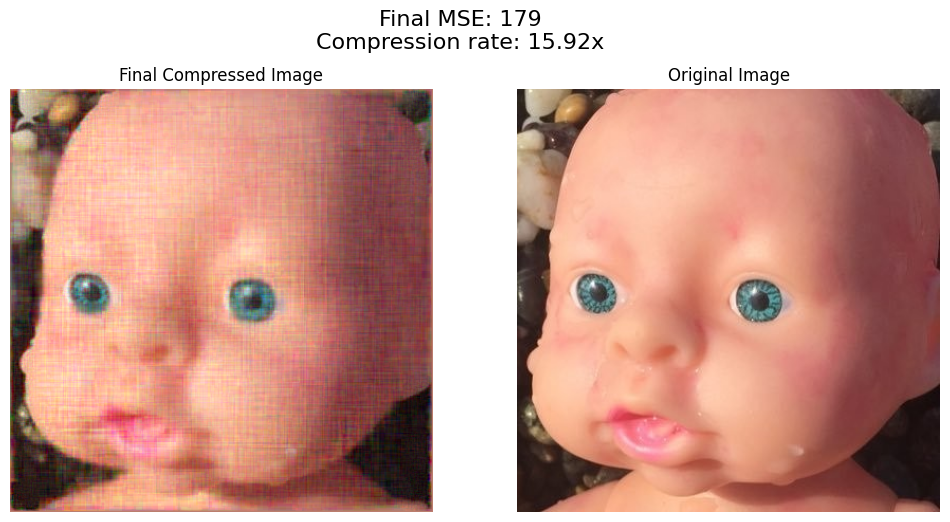

In [22]:
img = Image.open("./test_images/demonbaby.png")
save_filename = "numba_newtest_demonbaby.pbc"
video_filename = "compression_evolution_4.mp4"
print(img.size)
stroke_count = 30000
stream_interval = 160
FPS = 60

compress_and_generate_video(
    img,
    stroke_count=stroke_count,
    stream_interval=stream_interval,
    fps=FPS,
    save_filename=save_filename,
    video_filename=video_filename,
)